In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import os, sys, time, pickle, math

### Load and process dataset

In [182]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [183]:
digits.target.shape

(1797,)

In [184]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

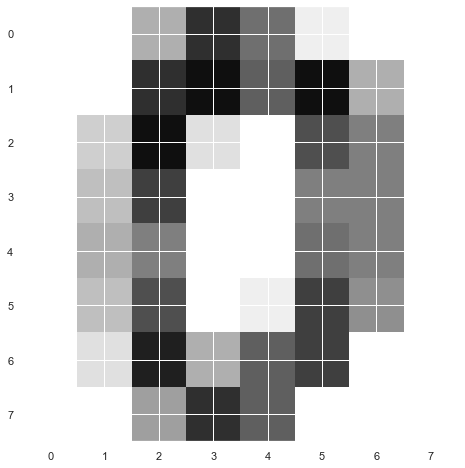

In [198]:
def plot_one_digit(data):
    if len(data.shape) == 1:
        data = data.reshape(8, 8)
    fig, ax = plt.subplots(1,1,figsize=(8, 8))
    im = ax.imshow(data, cmap='binary')
    im.set_clim(0, 16)

plot_one_digit(digits.data[0])


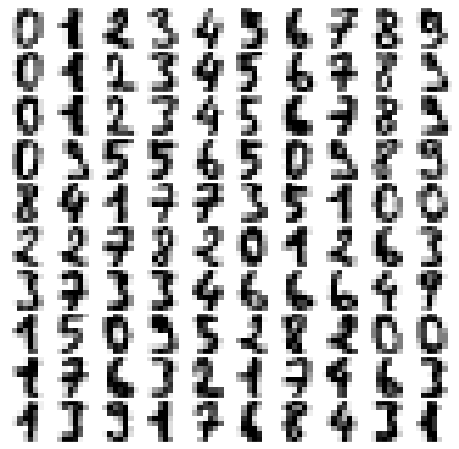

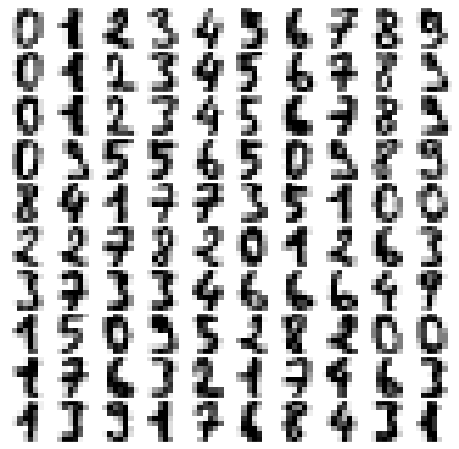

In [217]:
def plot_digits(data, chang=10, kuan=10):
    fig, ax = plt.subplots(chang, kuan, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        #data_thresh = np.array([0 if xi < 4 else xi for xi in data[i]])
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    return fig

plot_digits(digits.data)

In [5]:
data_fname = '../datasets/MNIST/mnist_1797_afterPCA.npz'
np.savez(data_fname, data=data)

### Ground truth model?

In [186]:
gmm = GaussianMixture(5, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [187]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

In [15]:
gmm.means_

array([[-1.91089718e-01, -6.85952554e-01,  8.73435222e-01,
        -2.10498365e-01, -2.60985529e-01, -4.59922062e-01,
         2.05759905e-01, -3.80113325e-01,  5.08525299e-02,
        -9.10599494e-02,  4.72916075e-01, -1.13617125e-01,
        -5.95369270e-02, -7.35212375e-02,  1.04142421e-01,
        -2.57732192e-01,  1.67213962e-01, -4.39025323e-03,
        -2.57388651e-02,  2.07377863e-01, -6.14582977e-02,
         4.12093308e-02, -1.20199437e-01, -1.17128148e-02,
         1.75447689e-04,  1.93366142e-02,  6.36167194e-02,
        -4.99154565e-03,  2.26157756e-02,  1.90230676e-01,
        -1.00665838e-02, -2.13774744e-04,  3.70055204e-02,
        -3.20236802e-02,  6.77909181e-03, -7.19360359e-02,
         7.82230211e-02, -5.59625978e-02, -3.09633091e-02,
        -1.82617281e-02, -4.18485608e-02],
       [ 4.02744356e-01, -8.74712903e-01, -4.47484155e-01,
         8.64173993e-01,  1.38465389e-01,  2.41390093e-01,
         3.99714990e-02,  1.50135087e-01,  2.40745449e-02,
        -4.71

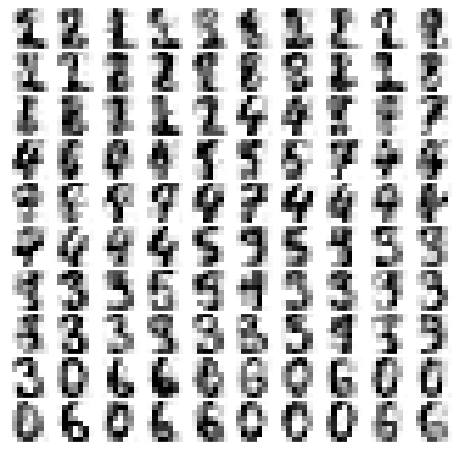

In [218]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new).savefig('foo.png', bbox_inches='tight')

### EM Results from us

In [28]:
def import_result_EM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["cov"] for r in res1]
    loss = [r["loss"] for r in res1]
    iters = [r["iters"] for r in res1]
    time = [r["time"] for r in res1]
    init_guess = [r["init_guess"] for r in res1]
    return pi, mu, conv, loss, iters, time, init_guess

In [44]:
k5 = import_result_EM("results/MNIST/EM/EM-K=5-lam=0-N=1797.p")

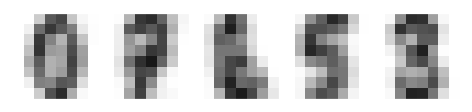

In [47]:
plot_digits(pca.inverse_transform(k5[1][0]), chang=1, kuan = 5)

In [50]:
k10 = import_result_EM("results/MNIST/EM/EM-K=10-lam=0-N=1797.p")

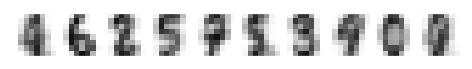

In [65]:
plot_digits(pca.inverse_transform(k10[1][1]), chang=1, kuan = 10)

In [39]:
k2[1][0].shape

(2, 41)

## Oracle

basic stuff

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
batch_size_train = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10
torch.backends.cudnn.enabled = False

In [126]:
from sklearn.model_selection import train_test_split

data = [[x.reshape((8, 8))] for x in digits.data]

X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2, random_state=42)

In [127]:
X_train_batch = []
Y_train_batch = []

In [128]:
i=0
while i < len(X_train)-batch_size_train:
    X_train_batch.append(torch.Tensor(X_train[i:i+batch_size_train]))
    Y_train_batch.append(torch.tensor(y_train[i:i+batch_size_train]))
    i += batch_size_train

X_train_batch.append(torch.Tensor(X_train[i:-1]))
Y_train_batch.append(torch.tensor(y_train[i:-1]))

In [129]:
X_test, y_test = torch.Tensor(X_test), torch.tensor(y_test)

In [96]:
train_losses = []
train_counter = []
test_losses = []

In [139]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=2)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 20)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [131]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(zip(X_train_batch, Y_train_batch)):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(X_train_batch),
                    100. * batch_idx / len(X_train_batch), loss.item()))
            train_losses.append(loss.item())

In [146]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        output = network(X_test)
        test_loss += F.nll_loss(output, y_test, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_test.view_as(pred)).sum()
    test_loss /= len(X_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(X_test),
    100. * correct / len(X_test)))
    return output.data.numpy(), pred.numpy()

In [140]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
test()
for epoch in range(1, 120):
    train(epoch)
    test()

/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3863, Accuracy: 74/360 (20%)

Train Epoch: 1 [0/23 (0%)]	Loss: 2.420635
Train Epoch: 1 [640/23 (43%)]	Loss: 2.291146
Train Epoch: 1 [1280/23 (87%)]	Loss: 2.270975

Test set: Avg. loss: 2.2404, Accuracy: 96/360 (26%)

Train Epoch: 2 [0/23 (0%)]	Loss: 2.230936
Train Epoch: 2 [640/23 (43%)]	Loss: 2.224312
Train Epoch: 2 [1280/23 (87%)]	Loss: 2.212016

Test set: Avg. loss: 2.1600, Accuracy: 129/360 (35%)

Train Epoch: 3 [0/23 (0%)]	Loss: 2.155740
Train Epoch: 3 [640/23 (43%)]	Loss: 2.127355
Train Epoch: 3 [1280/23 (87%)]	Loss: 2.108495

Test set: Avg. loss: 2.0229, Accuracy: 168/360 (46%)

Train Epoch: 4 [0/23 (0%)]	Loss: 2.030064
Train Epoch: 4 [640/23 (43%)]	Loss: 1.961360
Train Epoch: 4 [1280/23 (87%)]	Loss: 1.923768

Test set: Avg. loss: 1.8042, Accuracy: 186/360 (51%)

Train Epoch: 5 [0/23 (0%)]	Loss: 1.826366
Train Epoch: 5 [640/23 (43%)]	Loss: 1.722708
Train Epoch: 5 [1280/23 (87%)]	Loss: 1.664731

Test set: Avg. loss: 1.5284, Accuracy: 193/360 (53%)

Train E

Train Epoch: 46 [1280/23 (87%)]	Loss: 0.165280

Test set: Avg. loss: 0.2754, Accuracy: 332/360 (92%)

Train Epoch: 47 [0/23 (0%)]	Loss: 0.135066
Train Epoch: 47 [640/23 (43%)]	Loss: 0.180666
Train Epoch: 47 [1280/23 (87%)]	Loss: 0.155466

Test set: Avg. loss: 0.2751, Accuracy: 331/360 (91%)

Train Epoch: 48 [0/23 (0%)]	Loss: 0.131651
Train Epoch: 48 [640/23 (43%)]	Loss: 0.175103
Train Epoch: 48 [1280/23 (87%)]	Loss: 0.149642

Test set: Avg. loss: 0.2777, Accuracy: 330/360 (91%)

Train Epoch: 49 [0/23 (0%)]	Loss: 0.130838
Train Epoch: 49 [640/23 (43%)]	Loss: 0.172357
Train Epoch: 49 [1280/23 (87%)]	Loss: 0.146621

Test set: Avg. loss: 0.2787, Accuracy: 330/360 (91%)

Train Epoch: 50 [0/23 (0%)]	Loss: 0.126019
Train Epoch: 50 [640/23 (43%)]	Loss: 0.167389
Train Epoch: 50 [1280/23 (87%)]	Loss: 0.143153

Test set: Avg. loss: 0.2816, Accuracy: 330/360 (91%)

Train Epoch: 51 [0/23 (0%)]	Loss: 0.124808
Train Epoch: 51 [640/23 (43%)]	Loss: 0.169836
Train Epoch: 51 [1280/23 (87%)]	Loss: 0.13536

Train Epoch: 90 [1280/23 (87%)]	Loss: 0.041553

Test set: Avg. loss: 0.2386, Accuracy: 339/360 (94%)

Train Epoch: 91 [0/23 (0%)]	Loss: 0.024885
Train Epoch: 91 [640/23 (43%)]	Loss: 0.051721
Train Epoch: 91 [1280/23 (87%)]	Loss: 0.039557

Test set: Avg. loss: 0.2335, Accuracy: 340/360 (94%)

Train Epoch: 92 [0/23 (0%)]	Loss: 0.023762
Train Epoch: 92 [640/23 (43%)]	Loss: 0.049175
Train Epoch: 92 [1280/23 (87%)]	Loss: 0.038954

Test set: Avg. loss: 0.2316, Accuracy: 341/360 (94%)

Train Epoch: 93 [0/23 (0%)]	Loss: 0.023763
Train Epoch: 93 [640/23 (43%)]	Loss: 0.048453
Train Epoch: 93 [1280/23 (87%)]	Loss: 0.036162

Test set: Avg. loss: 0.2227, Accuracy: 343/360 (95%)

Train Epoch: 94 [0/23 (0%)]	Loss: 0.023462
Train Epoch: 94 [640/23 (43%)]	Loss: 0.045937
Train Epoch: 94 [1280/23 (87%)]	Loss: 0.038393

Test set: Avg. loss: 0.2277, Accuracy: 341/360 (94%)

Train Epoch: 95 [0/23 (0%)]	Loss: 0.023434
Train Epoch: 95 [640/23 (43%)]	Loss: 0.045341
Train Epoch: 95 [1280/23 (87%)]	Loss: 0.03207

Train Epoch: 134 [1280/23 (87%)]	Loss: 0.008262

Test set: Avg. loss: 0.2087, Accuracy: 344/360 (95%)

Train Epoch: 135 [0/23 (0%)]	Loss: 0.008215
Train Epoch: 135 [640/23 (43%)]	Loss: 0.018695
Train Epoch: 135 [1280/23 (87%)]	Loss: 0.008189

Test set: Avg. loss: 0.2090, Accuracy: 344/360 (95%)

Train Epoch: 136 [0/23 (0%)]	Loss: 0.007993
Train Epoch: 136 [640/23 (43%)]	Loss: 0.018470
Train Epoch: 136 [1280/23 (87%)]	Loss: 0.008034

Test set: Avg. loss: 0.2082, Accuracy: 344/360 (95%)

Train Epoch: 137 [0/23 (0%)]	Loss: 0.008048
Train Epoch: 137 [640/23 (43%)]	Loss: 0.017457
Train Epoch: 137 [1280/23 (87%)]	Loss: 0.007928

Test set: Avg. loss: 0.2086, Accuracy: 344/360 (95%)

Train Epoch: 138 [0/23 (0%)]	Loss: 0.007774
Train Epoch: 138 [640/23 (43%)]	Loss: 0.017420
Train Epoch: 138 [1280/23 (87%)]	Loss: 0.007589

Test set: Avg. loss: 0.2094, Accuracy: 344/360 (95%)

Train Epoch: 139 [0/23 (0%)]	Loss: 0.007926
Train Epoch: 139 [640/23 (43%)]	Loss: 0.016935
Train Epoch: 139 [1280/23 (87%


Test set: Avg. loss: 0.2203, Accuracy: 343/360 (95%)

Train Epoch: 179 [0/23 (0%)]	Loss: 0.004818
Train Epoch: 179 [640/23 (43%)]	Loss: 0.008410
Train Epoch: 179 [1280/23 (87%)]	Loss: 0.004040

Test set: Avg. loss: 0.2203, Accuracy: 343/360 (95%)

Train Epoch: 180 [0/23 (0%)]	Loss: 0.004709
Train Epoch: 180 [640/23 (43%)]	Loss: 0.008366
Train Epoch: 180 [1280/23 (87%)]	Loss: 0.004003

Test set: Avg. loss: 0.2209, Accuracy: 343/360 (95%)

Train Epoch: 181 [0/23 (0%)]	Loss: 0.004648
Train Epoch: 181 [640/23 (43%)]	Loss: 0.008047
Train Epoch: 181 [1280/23 (87%)]	Loss: 0.003946

Test set: Avg. loss: 0.2217, Accuracy: 343/360 (95%)

Train Epoch: 182 [0/23 (0%)]	Loss: 0.004572
Train Epoch: 182 [640/23 (43%)]	Loss: 0.007941
Train Epoch: 182 [1280/23 (87%)]	Loss: 0.003920

Test set: Avg. loss: 0.2213, Accuracy: 343/360 (95%)

Train Epoch: 183 [0/23 (0%)]	Loss: 0.004486
Train Epoch: 183 [640/23 (43%)]	Loss: 0.007938
Train Epoch: 183 [1280/23 (87%)]	Loss: 0.003810

Test set: Avg. loss: 0.2224, 

In [148]:
ar, pred = test()


Test set: Avg. loss: 0.2303, Accuracy: 343/360 (95%)



/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [151]:
import scipy

In [155]:
(scipy.special.softmax(ar[0])*100).round(3)

array([1.1000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 9.8746e+01, 0.0000e+00, 1.2420e+00, 0.0000e+00],
      dtype=float32)

In [213]:
count = 0
for x in ar:
    if max(scipy.special.softmax(x)) > 0.80:
        count += 1
print(count/float(len(ar)))

0.9722222222222222


/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


0.07222222222222222


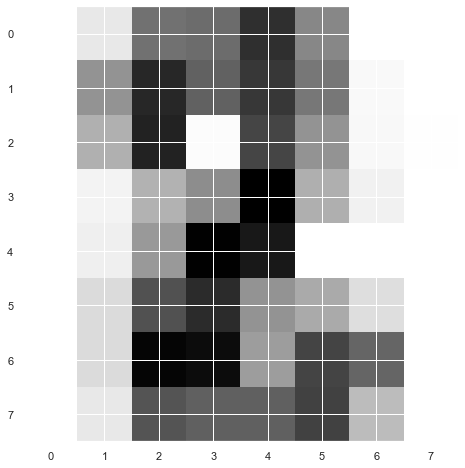

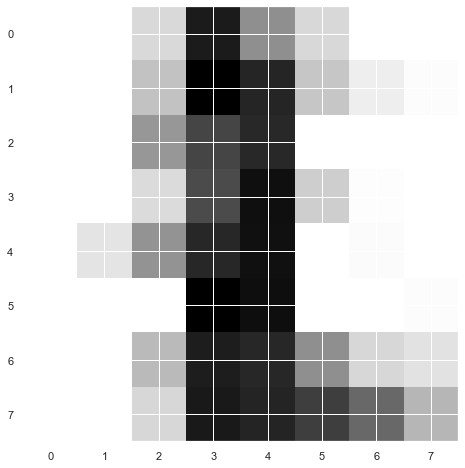

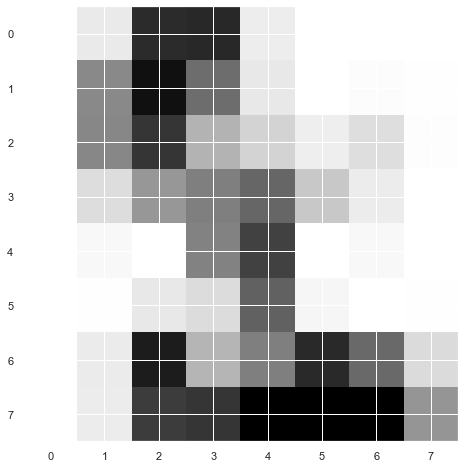

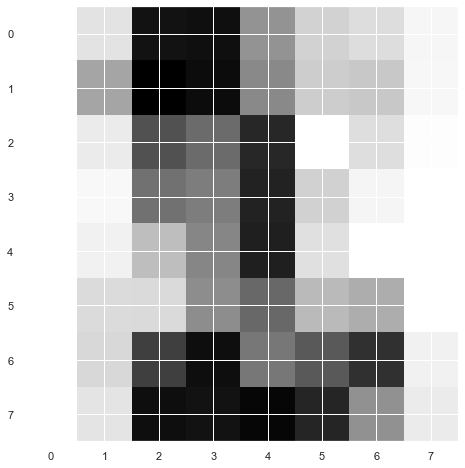

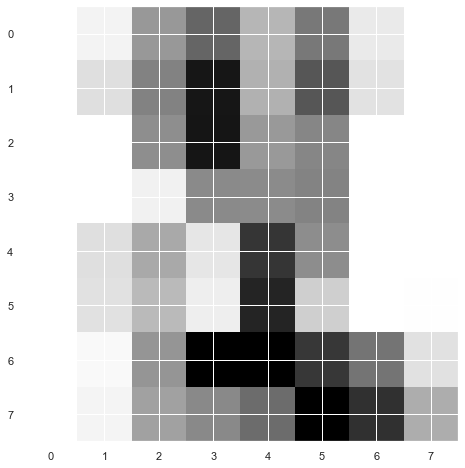

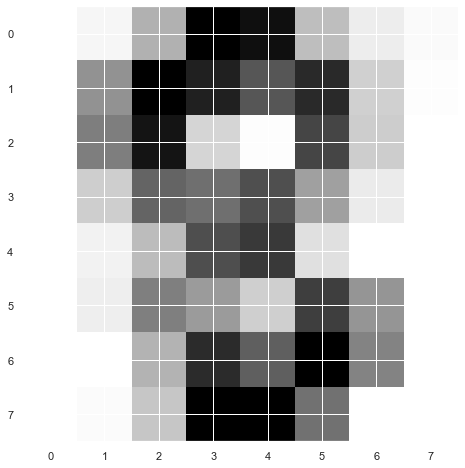

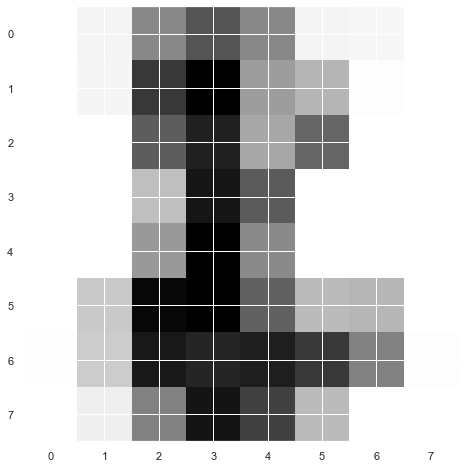

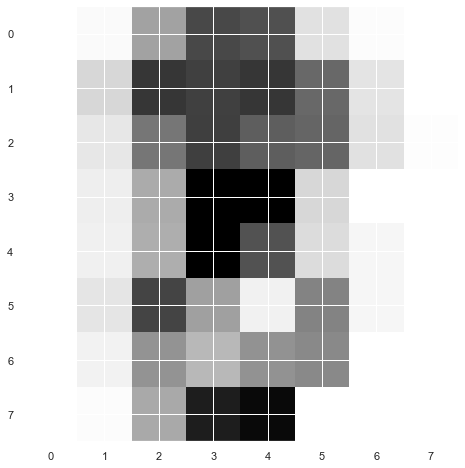

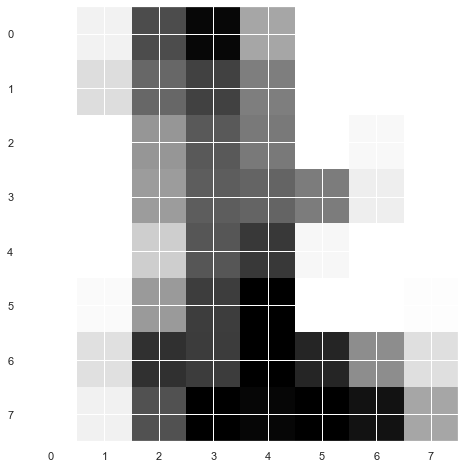

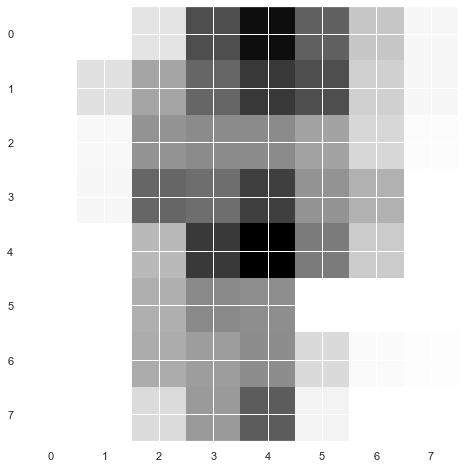

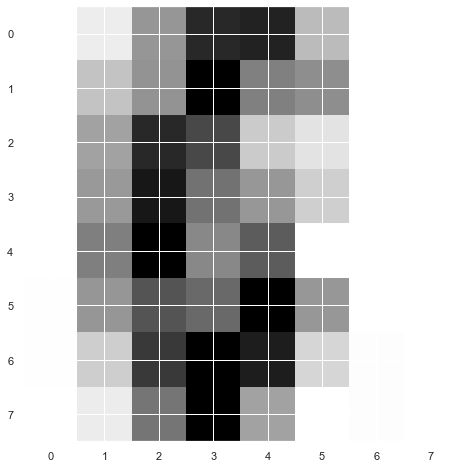

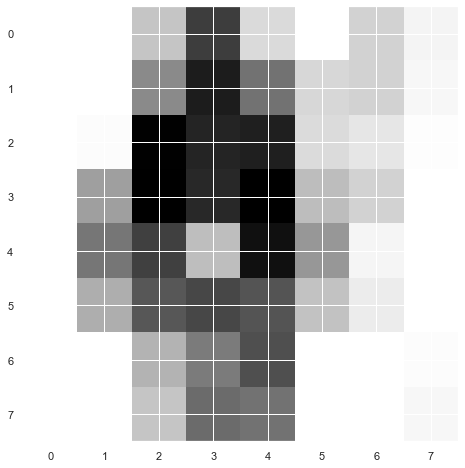

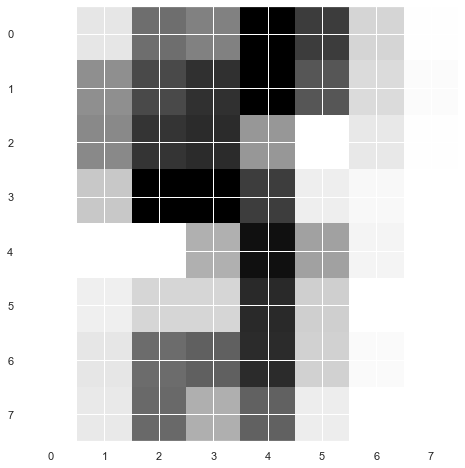

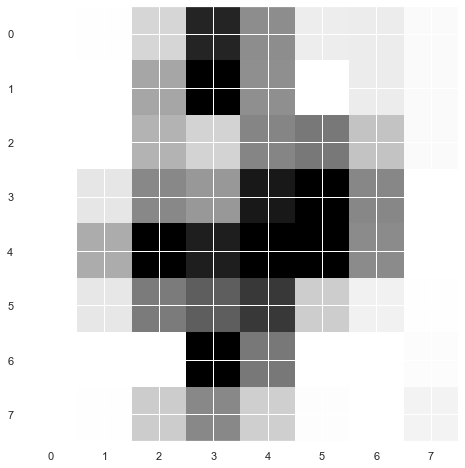

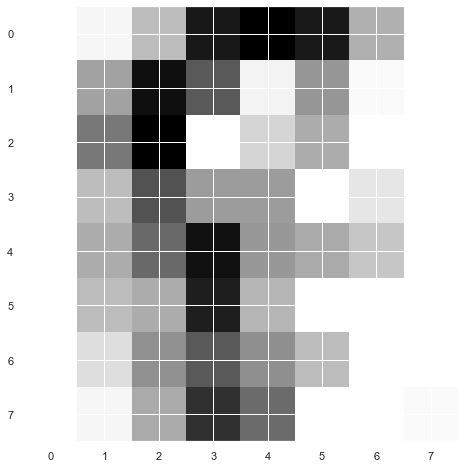

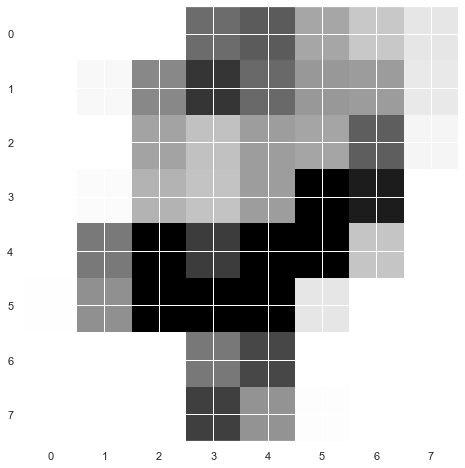

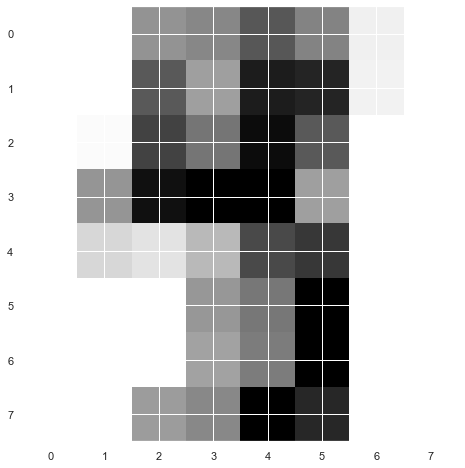

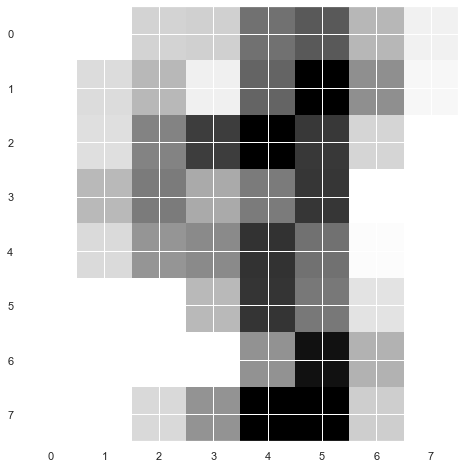

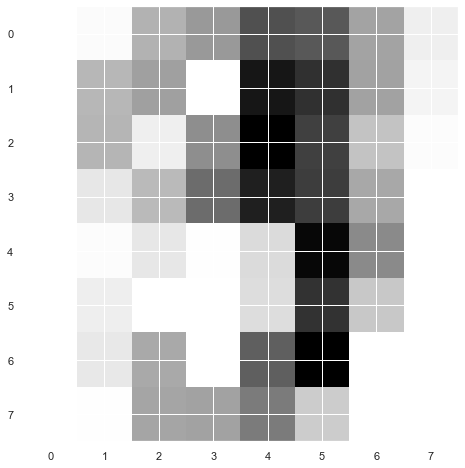

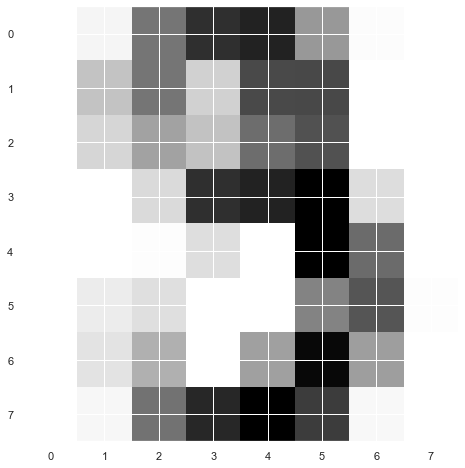

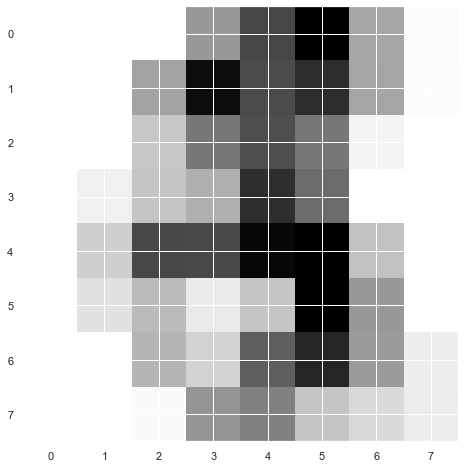

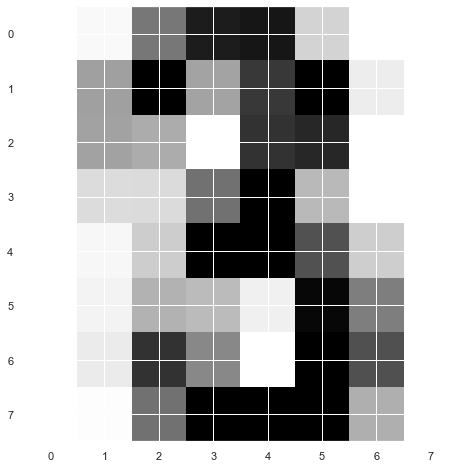

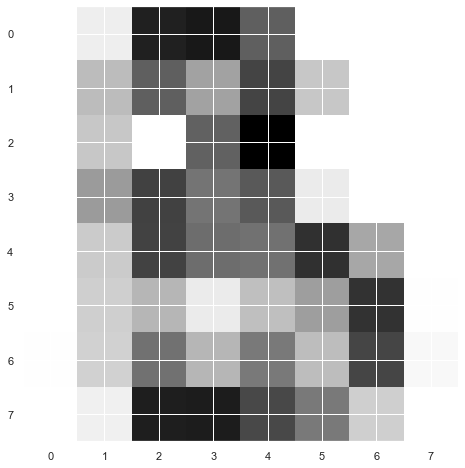

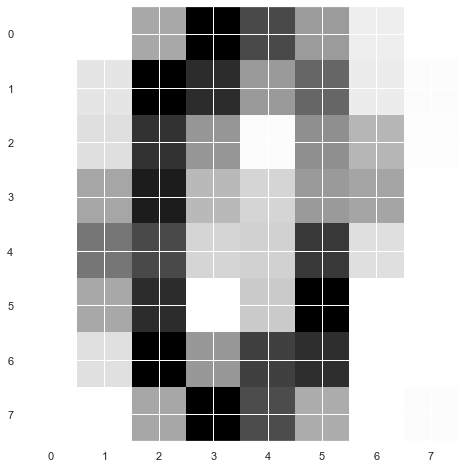

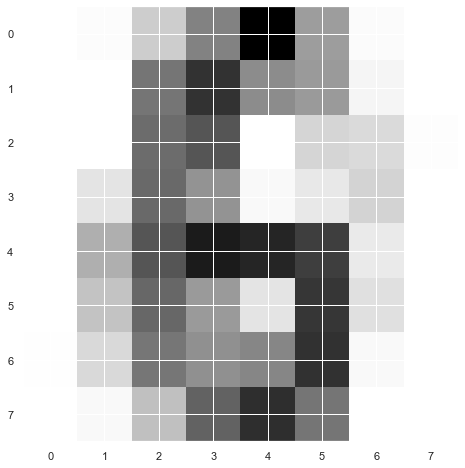

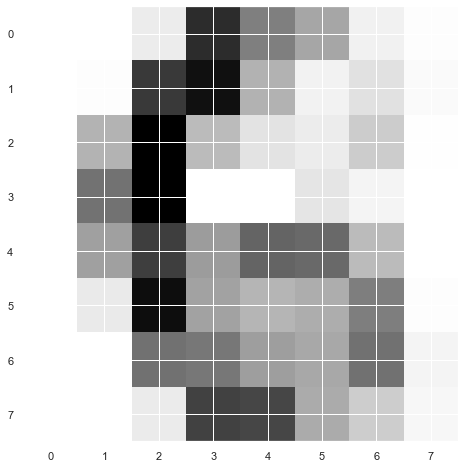

In [216]:
gen_data = torch.Tensor([[x.reshape((8, 8))] for x in digits_new])
ar_gen = network(gen_data).detach().numpy()
count = 0
for i,x in enumerate(ar_gen):
    if max(scipy.special.softmax(x)) < 0.90:
        count += 1
        plot_one_digit(digits_new[i])
print(count/float(len(ar)))

In [150]:
ar[0],pred[0]

(array([-9.0941620e+00, -2.2423744e+01, -2.6986202e+01, -3.9586338e+01,
        -1.2309749e+01, -1.6236206e+01, -1.2617111e-02, -2.1711540e+01,
        -4.3883705e+00, -1.5743701e+01], dtype=float32), array([6]))

In [163]:
output = network(torch.Tensor([np.random.rand(1,8,8)])).detach().numpy()

/Users/sophiasun/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [164]:
(scipy.special.softmax(output)*100).round(3)

array([[16.506,  2.539,  4.22 ,  3.712, 11.414,  5.165, 10.91 , 11.858,
        23.345, 10.331]], dtype=float32)

In [204]:
torch.save(network.state_dict(), './model95.pth')

using a bayesian network


https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd

https://github.com/paraschopra/bayesian-neural-network-mnist/blob/master/bnn.ipynb

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

In [17]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

NameError: name 'transforms' is not defined

In [7]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [11]:
def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [ ]:
model = NN(8*8, 256, 10)
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)